In [5]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit_v2/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain, read_eqdsk, save_gs_mesh

from omfit_classes.omfit_eqdsk import boundaryShape

In [6]:
plasma_dx = 0.02
coil_dx = 0.04
vv_dx = 0.01
vac_dx = 0.05

In [7]:
import json
with open('nsf_geom_new.json','r') as fid:
    nsf_geom = json.load(fid)

In [21]:
def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

def corners(r,z,dr,dz):
    rs = np.array([r+dr/2, r+dr/2, r-dr/2, r-dr/2, r+dr/2])
    zs = np.array([z+dz/2, z-dz/2, z-dz/2, z+dz/2, z+dz/2])
    return np.column_stack((rs,zs))

r,z,zeff= boundaryShape(kapu = 1.55, kapl = 1.55, delu = -0.4, dell = -0.4, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.413, eps = 0.413/1.04, zoffset = 0, upnull = False, lonull = False, npts = 8)
lim1 = np.column_stack((r,z))

lim2 = resize_polygon(lim1, -0.05)
vv2 = resize_polygon(lim2, 0.01)


In [22]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')                     # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')                 # Define the plasma region and resolution
gs_mesh.define_region('vv',vv_dx,'conductor',eta=8.6E-7)

# Define each of the PF coils
gs_mesh.define_region('CS_1',coil_dx,'coil')
gs_mesh.define_region('CS_2',coil_dx,'coil')
gs_mesh.define_region('CS_3',coil_dx,'coil')
gs_mesh.define_region('PF_1U',coil_dx,'coil')
gs_mesh.define_region('PF_1L',coil_dx,'coil')
gs_mesh.define_region('PF_2U',coil_dx,'coil')
gs_mesh.define_region('PF_2L',coil_dx,'coil')
gs_mesh.define_region('PF_3U',coil_dx,'coil')
gs_mesh.define_region('PF_3L',coil_dx,'coil')
gs_mesh.define_region('PF_4U',coil_dx,'coil')
gs_mesh.define_region('PF_4L',coil_dx,'coil')




In [23]:
# Define geometry
gs_mesh.add_annulus(lim2, 'plasma', vv2, 'vv', parent_name = 'air')

# Define each of the PF coils
gs_mesh.add_rectangle(0.59991,0.57,.07492,0.36,'CS_1',parent_name = 'air')
gs_mesh.add_rectangle(0.59991,0,.07492,.72,'CS_2',parent_name = 'air')
gs_mesh.add_rectangle(0.59991,-0.57,.07492,0.36,'CS_3',parent_name = 'air')

gs_mesh.add_polygon(np.array(nsf_geom['PF1U'])/1000,'PF_1U',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF1L'])/1000,'PF_1L',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF2U'])/1000, 'PF_2U',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF2L'])/1000, 'PF_2L',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF3U'])/1000, 'PF_3U',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF3L'])/1000, 'PF_3L',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF4U'])/1000, 'PF_4U',parent_name = 'air')
gs_mesh.add_polygon(np.array(nsf_geom['PF4L'])/1000,'PF_4L',parent_name = 'air')



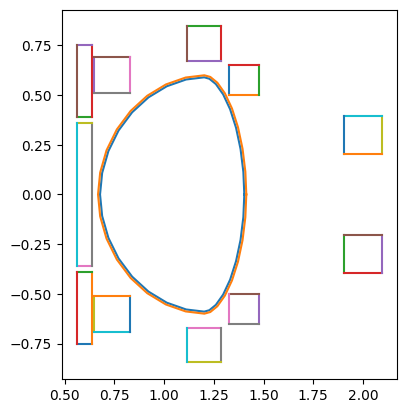

In [24]:
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

In [25]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 991
  # of unique segments  = 50
Generating mesh:
  # of points  = 6431
  # of cells   = 12680
  # of regions = 14


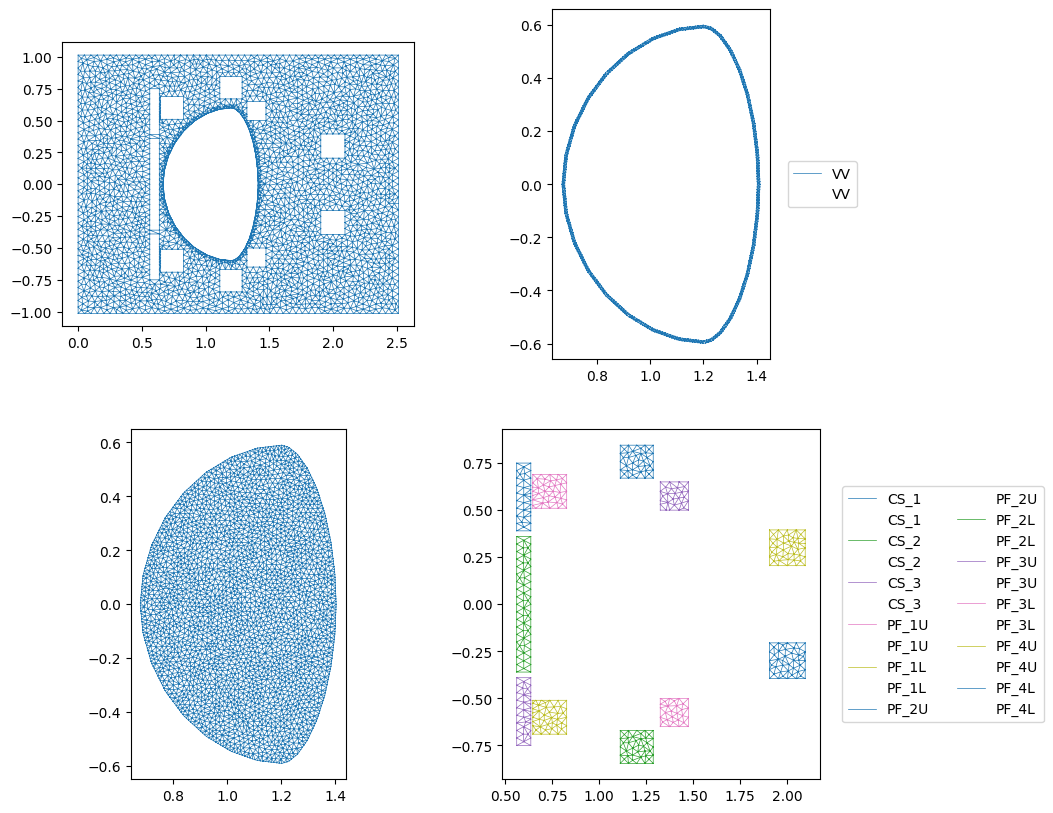

In [26]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==2,:],lw=0.5)
ax[1,0].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==1,:],lw=0.5)
for key, cond in cond_dict.items():
    ax[0,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==cond['reg_id'],:],lw=0.5,label=key)
for key, coil in coil_dict.items():
    ax[1,1].triplot(mesh_pts[:,0],mesh_pts[:,1],mesh_lc[mesh_reg==coil['reg_id'],:],lw=0.5,label=key)
for ax_tmp in ax.flatten():
    ax_tmp.set_aspect('equal','box')
ax[0,1].legend(bbox_to_anchor=(1.05,0.5), loc='center left')
_ = ax[1,1].legend(bbox_to_anchor=(1.05,0.5), ncol=2, loc='center left')

In [27]:
save_gs_mesh(mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict,'nextstep_mesh_vs.h5')